In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

from load_wastewater_data import *

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution"
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_dynamics", "constant_decay_dynamics"

In [3]:
df = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")

In [4]:
plot_path = f"../plots/sampling_strategies"
os.makedirs(os.path.join(plot_path), exist_ok=True)
file_name_prefix = f"{resolution}_{rain_scenario}_{degradation_setting}"

In [5]:
df["time"] = pd.Timestamp("2024-01-01") + pd.to_timedelta(df["minutes"], unit="minutes")

## Preprocessing

In [6]:
def simulate_sampling_strategies(df, resolution):
    df.time = pd.to_datetime(df.time)
    df["day"]= [el.day for el in df.time]
    df["hour"] = [el.hour for el in df.time]

    # resample every 3 minutes and fill with the last available value
    resampled_df = df.set_index("time").groupby(["sampling_point", "memilio_id"]).resample(f"{resolution}min").ffill()
    # get hourly measurements
    resampled_df = resampled_df.loc[resampled_df.minutes.mod(60) == 0,:]
    # fix column naming and index
    resampled_df.index = [el[2] for el in resampled_df.index]
    resampled_df = resampled_df.reset_index().rename(columns={"index": "time"})
    # calculate 24h samples
    df_24h = resampled_df.groupby(["sampling_point", "memilio_id", "day"]).mean().reset_index().rename(columns={"COVID_copies/l": "COVID_24h_sample", "PMMoV_copies/l": "PMMoV_24h_sample"})
    # only consider 24h samples with 24h of data
    df_24h = df_24h.loc[df_24h.hour==11.5, ["time", "time_in_days", "sampling_point", "memilio_id", "COVID_24h_sample", "PMMoV_24h_sample"]]
    # extract morning sample column
    df_morning_sample = resampled_df.loc[resampled_df.hour==10,:].rename(columns={"COVID_copies/l": "COVID_morning_sample", "PMMoV_copies/l": "PMMoV_morning_sample"}).loc[:,  ["time", "time_in_days", "sampling_point", "memilio_id", "COVID_morning_sample", "PMMoV_morning_sample"]]
    # combine everything
    df_measurements = pd.merge(df, pd.merge(df_24h, df_morning_sample, on=["sampling_point", "memilio_id", "time", "time_in_days"], how="outer"), on=["sampling_point", "memilio_id", "time", "time_in_days"], how="outer")
    return df_measurements

In [7]:
df_sampling = simulate_sampling_strategies(df, 3)

## Metrics

In [52]:
sampling_point = "16"

In [53]:
metric_24h_sample = df_sampling[["time_in_days", "sampling_point", "memilio_id", "COVID_24h_sample", "COVID_copies/l"]].copy()
metric_24h_sample = metric_24h_sample.loc[metric_24h_sample.sampling_point==sampling_point]

# take average across simulations
metric_24h_sample = metric_24h_sample.groupby("time_in_days")[["COVID_24h_sample", "COVID_copies/l"]].mean().sort_index()
# interpolate linearly between 24h samples
metric_24h_sample["COVID_24h_sample"] = metric_24h_sample["COVID_24h_sample"].interpolate(method="linear")
# calculate MAE
metric_24h_sample["MAE"] = np.abs(metric_24h_sample["COVID_24h_sample"] - metric_24h_sample["COVID_copies/l"])

In [54]:
metric_24h_sample.describe()

,COVID_24h_sample,COVID_copies/l,MAE
count,6011.000000,6720.000000,6011.000000
mean,278.471544,264.236656,4.749228
std,48.099301,67.327211,4.506333
min,212.653943,0.000000,0.000314
25%,242.237678,232.932054,1.253958
50%,254.559153,253.399034,3.163887
75%,314.234062,303.801367,6.956179
max,374.264593,390.978773,22.822757


In [55]:
metric_morning_sample = df_sampling[["time_in_days", "sampling_point", "memilio_id", "COVID_morning_sample", "COVID_copies/l"]].copy()
metric_morning_sample = metric_morning_sample.loc[metric_morning_sample.sampling_point==sampling_point]

# take average across simulations
metric_morning_sample = metric_morning_sample.groupby("time_in_days")[["COVID_morning_sample", "COVID_copies/l"]].mean().sort_index()
# interpolate linearly between 24h samples
metric_morning_sample["COVID_morning_sample"] = metric_morning_sample["COVID_morning_sample"].interpolate(method="linear")
# calculate MAE
metric_morning_sample["MAE"] = np.abs(metric_morning_sample["COVID_morning_sample"] - metric_morning_sample["COVID_copies/l"])

In [56]:
metric_morning_sample.describe()

,COVID_morning_sample,COVID_copies/l,MAE
count,6521.000000,6720.000000,6521.000000
mean,270.583840,264.236656,4.026894
std,58.101815,67.327211,4.127943
min,97.509173,0.000000,0.000000
25%,236.864685,232.932054,0.915788
50%,256.115633,253.399034,2.422356
75%,308.367664,303.801367,6.591737
max,379.424339,390.978773,24.158827


In [57]:
MAE_df = pd.DataFrame({"24h_sample": metric_24h_sample["MAE"], "morning_sample": metric_morning_sample["MAE"]})

/tmp/ipykernel_18537/3077502499.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["24h sample", "morning sample"], fontsize=18)


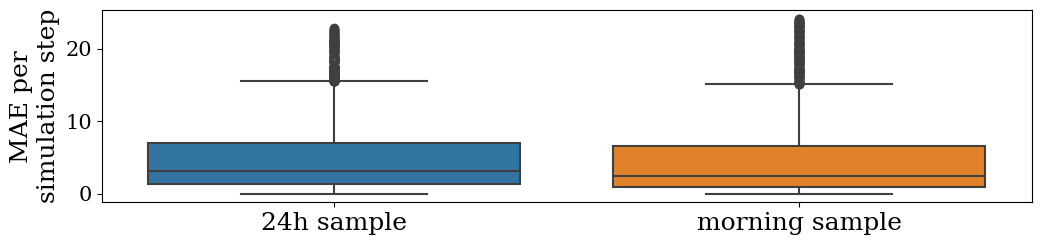

In [58]:
fig, ax = plt.subplots(figsize = (12,2.5))
sns.boxplot(data=MAE_df, linewidth=1.5)
ax.set_ylabel(f"MAE per\nsimulation step", fontsize=18)
ax.set_xticklabels(["24h sample", "morning sample"], fontsize=18)
ax.tick_params(axis='y', labelsize=15)


## Visualizations

In [63]:
# from wide to long
df_sampling = pd.melt(df_sampling, id_vars=["time_in_days", "sampling_point", "memilio_id"], value_vars=["COVID_24h_sample", "COVID_morning_sample", "COVID_copies/l"]).dropna()

In [64]:
df_sampling.head()

,time_in_days,sampling_point,memilio_id,variable,value
35,1.479167,1,1,COVID_24h_sample,15.521225
60,2.479167,1,1,COVID_24h_sample,51.174760
85,3.479167,1,1,COVID_24h_sample,258.869092
110,4.479167,1,1,COVID_24h_sample,535.638537
135,5.479167,1,1,COVID_24h_sample,709.440920


In [68]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [73]:
def plot_sampling_strategies(df_sampling, station, save_fig=False):
    fig, ax = plt.subplots(figsize = (12,6)) 
    sns.lineplot(df_sampling.loc[df_sampling.sampling_point==station, :], x="time_in_days", y="value", hue="variable")
    plt.ylabel('virus levels [copies/l]', fontsize=20)
    ax.set_xlabel(f"simulation time [days]", fontsize=20)
    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels, ['24h sample', 'morning sample','simulation result'], title="sampling protocol", fontsize=15)    
    if save_fig:
        plt.tight_layout()
        plt.savefig(os.path.join(plot_path, f"{file_name_prefix}_station_{station}.png"))
        plt.close(fig)
    else:
        plt.close(fig)
        return fig

In [74]:
df_sampling.variable.unique()

array(['COVID_24h_sample', 'COVID_morning_sample', 'COVID_copies/l'],
      dtype=object)

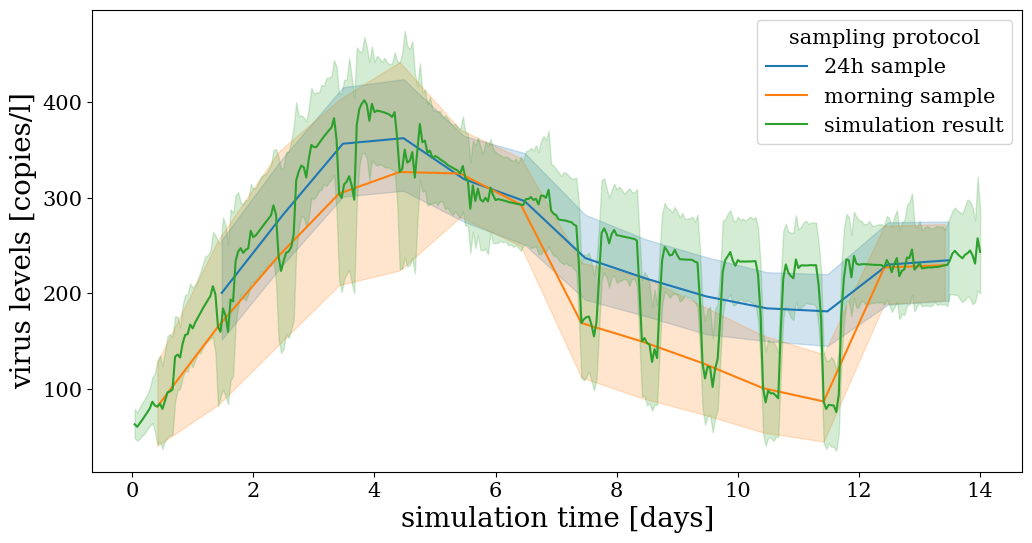

In [75]:
plot_sampling_strategies(df_sampling, "1", save_fig=False)

In [76]:
for station in ["1", "11", "16"]: # ["1", "2", "8", "16"]: # df_sampling.sampling_point.unique():
    plot_sampling_strategies(df_sampling, station, save_fig=True)